## **Vehicle Detection Project**   
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import numpy as np
import cv2
import sklearn
import skimage
import glob
import os
import time
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
# NOTE: : the next import is only valid for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# for scikit-learn version <= 0.17 
#from sklearn.cross_validation import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML

print('OK!')

OK!


## Step 1: make a list of image to read in

In [2]:
car_images = glob.glob('training_dataset/vehicles/**/*.png')
noncar_images = glob.glob('training_dataset/non-vehicles/**/*.png')
car_images_num = len(car_images)
noncar_images_num = len(noncar_images)
print("Vehicles images = ", car_images_num)
print("Non Vehicles images = " , noncar_images_num)

Vehicles images =  8792
Non Vehicles images =  8968


### Visualize Some Training Data

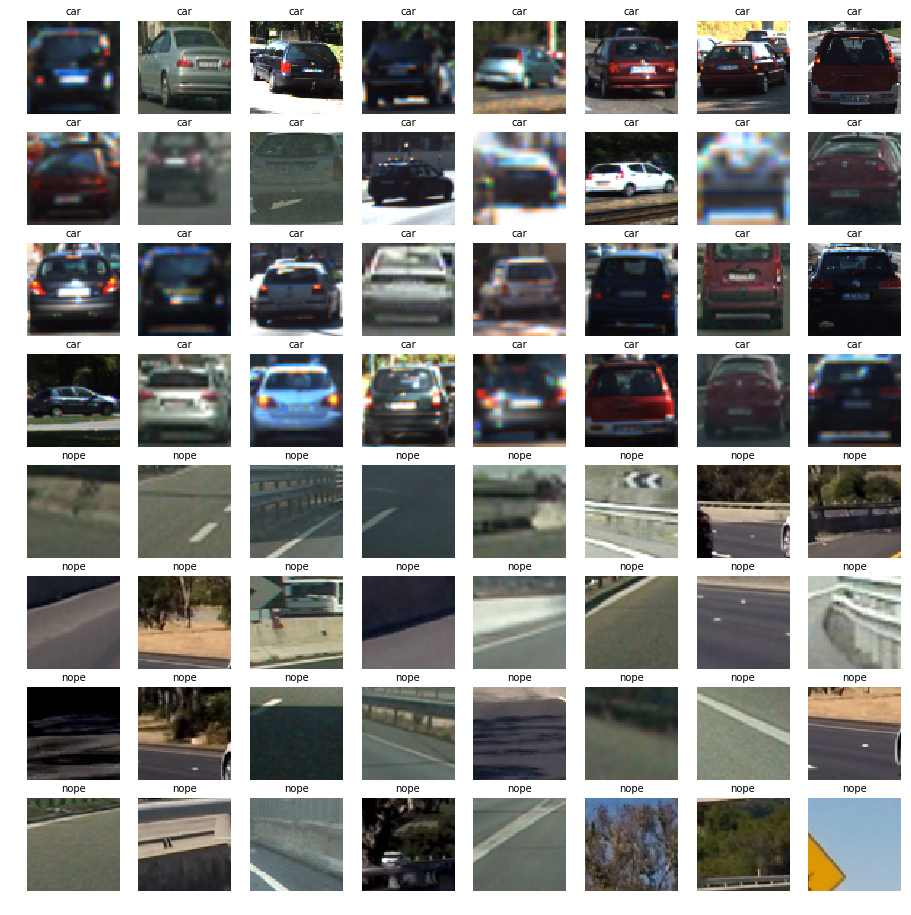

In [3]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)

## Define Method to Get Histogram of Oriented Gradients (HOG) Features
*This method was duplicated from lesson materials*

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Extract one image HOG feature
    
    Arguments:
        img: source image
        orient: split 360˚ into orient parts
        pix_per_cell: pixels per cell
        cell_per_block: cells per block
        vis: bool, whether visualize the result
        feature_vec: bool, whether tansfer hog features into vector
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Visualize HOG on example image

Text(0.5,1,'Non-Car HOG')

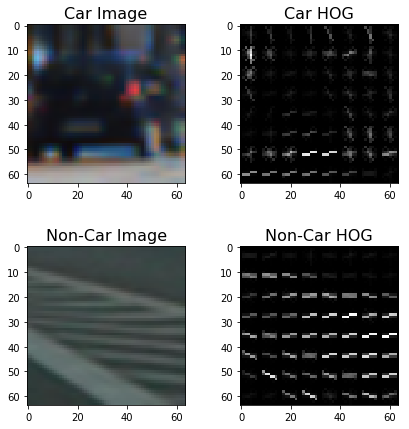

In [5]:
car_img = mpimg.imread(car_images[np.random.randint(car_images_num)])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[np.random.randint(car_images_num)])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

## Method to Extract HOG Features from an Array of Car and Non-Car Images
---
*The code for this method was mostly duplicated from course lesson material.*

In [6]:
# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """
    Extract HOG feature of series images
    
    Arguments:
        imgs: source images
        cspace: color space HSV, RGB, HLS, YUV, YCrCb
        orient: split 360˚ into orient parts
        pix_per_cell: pixels per cell
        cell_per_block: cells per block
        hog_channel: which channel of image to extract HOG features
    """
    # Create a list to append feature vectors
    features = []
    # Iterate in each image one by one
    for file in imgs:
        # Read in each image one by one
        image = mpimg.imread(file)
        # Apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell,
                                                     cell_per_block, vis=False, feature_vec=True))
            
            hog_features = np.ravel(hog_features)
            
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell,
                                            cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of images feature vecotors
    return features

## Extract Features for Input Datasets and Combine, Define Labels Vector, Shuffle and Split

In [7]:
# Feature extraction parameters
colorspace = 'YUV' # RGB, YUV, LUV, HLS, HSV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # ALL, 0, 1, 2

t_start = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=hog_channel)
noncar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel)
t_end = time.time()
print("It takes ",round(t_end-t_start, 2), "seconds to extract HOG features...")
X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(car_images_num), np.zeros(noncar_images_num)))

# Split dataset into training data set and test data set
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print("Using: ",orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block.')
print('Feature vector length = ', len(X_train[0]))

It takes  49.65 seconds to extract HOG features...
Using:  11 orientations 16 pixels per cell and 2 cells per block.
Feature vector length =  1188


## Train Classifier

In [8]:
# Using a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print("It takes ", round(t2-t1, 2), "seconds to train SVC classifier...")
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t1 = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[:n_predict]))
print('For these', n_predict, 'labels:', y_test[:n_predict])
t2 = time.time()
print('It takes ', round(t2-t1, 5), 'seconds to predict', n_predict, 'samples with SVC classifier...')

It takes  0.99 seconds to train SVC classifier...
Test Accuracy of SVC =  0.9837
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
For these 10 labels: [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
It takes  0.00113 seconds to predict 10 samples with SVC classifier...


## Method for Using Classifier to Detect Cars in an Image¶
---
*This code is adapted from lesson material*

<img src="./readme_img/hog-visualization.jpg" width = "500" height = "400" alt="HOG Visualization" align=center />

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, 
              cell_per_block, show_all_rectangles=False):
    """
    Search cars in image
    
    Arguments:
        img: source image
        ystart: row begin to search
        ystop: row stop to search
        scale: rescale image
        cspace: color space
        hog_channel: which channel of image to extract HOG features
        svc: SVM Classifier
        orient: split 360˚ into orient parts
        pix_per_cell: pixels per cell
        cell_per_block: cells per block
        show_all_rectangles: bool, whether show all rectangles
    """
      
    # bording box of dected cars
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_to_search = img[ystart:ystop,:,:]
    
    # Apply color conversion if other than 'RGB' color space
    if cspace != 'RGB':
        if cspace == 'HSV':
            cvtimag_tosearch = cv2.cvtColor(img_to_search, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            cvtimag_tosearch = cv2.cvtColor(img_to_search, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            cvtimag_tosearch = cv2.cvtColor(img_to_search, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            cvtimag_tosearch = cv2.cvtColor(img_to_search, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            cvtimag_tosearch = cv2.cvtColor(img_to_search, cv2.COLOR_RGB2YCrCb)
    else:
        cvtimag_tosearch = np.copy(img)
    
    # Rescale image if other than 1.0 scale
    if scale != 1:
        imshape = cvtimag_tosearch.shape
        cvtimag_tosearch = cv2.resize(cvtimag_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Select colorspace channel for HOG
    if hog_channel == 'ALL':
        ch1 = cvtimag_tosearch[:,:,0]
        ch2 = cvtimag_tosearch[:,:,1]
        ch3 = cvtimag_tosearch[:,:,2]
    else:
        ch1 = cvtimag_tosearch[:,:,hog_channel]
    
    # Define blocks and steps as above
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxcells = ch1.shape[1] // pix_per_cell + 1
    nycells = ch1.shape[0] // pix_per_cell + 1
    #nxcells = math.ceil(ch1.shape[1]/pix_per_cell)
    #nycells = math.ceil(ch1.shape[0]/pix_per_cell)
#     print('nxcells = ', nxcells)
#     print('nycells = ', nycells)
    nfeat_per_block = orient*cell_per_block**2  # cells per block = (cell_per_block,cell_per_block)
    
    # 64 was the orginal sampling square area lenth, with 8 cells and 8 pix per cell
    window = 64
    ncells_per_window = window // pix_per_cell - 1
    nxsteps = (nxcells - ncells_per_window) // cells_per_step
    nysteps = (nycells - ncells_per_window) // cells_per_step
#     print('nxsteps = ', nxsteps) 
#     print('nysteps = ', nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     print('hog1.shape = ', hog1.shape)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extracct HOG for this patch
            hog_feat1 = hog1[ypos:ypos+ncells_per_window, xpos:xpos+ncells_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+ncells_per_window, xpos:xpos+ncells_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+ncells_per_window, xpos:xpos+ncells_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features.reshape(1, -1))
            
            if test_prediction == 1 or show_all_rectangles: 
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return rectangles

print('OK!') 

OK!


## Test Find_Cars on an Example Image

In [10]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                       pix_per_cell, cell_per_block)

print(len(rectangles), 'rectangles found in image')

4 rectangles found in image


## Method to Draw Rectangles onto an Image
---
*Duplicated from lesson material*

In [11]:
# Here is your draw_boxes function from the 'Manual Vehicle Detection' lesson
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('OK')

OK


Draw the rectangles onto the example image

OK


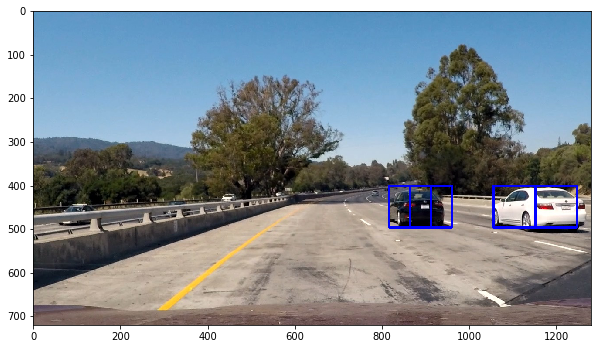

In [12]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('OK')

## Show All Potential Search Areas
Becuase the size and position of cars in the image will be different depending on their distance from the camera, find_cars will have to be called a few times with different ystart, ystop, and scale values. These next few blocks of code are for determining the values for these parameters that work best.

Number of boxes:  78


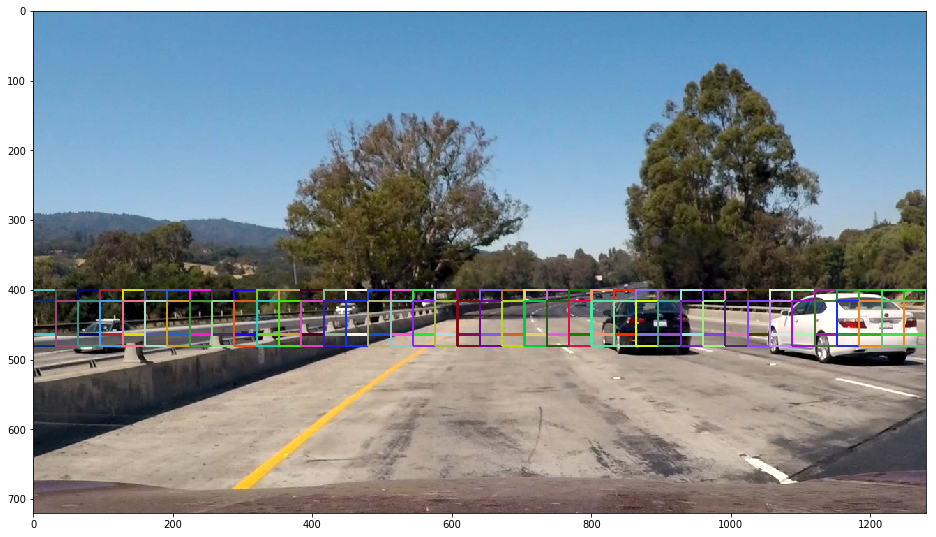

In [13]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0

find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                       pix_per_cell, cell_per_block, show_all_rectangles=True)
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                       pix_per_cell, cell_per_block, show_all_rectangles=True))

ystart = 416
ystop = 480
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                       pix_per_cell, cell_per_block, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(16,16))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  50


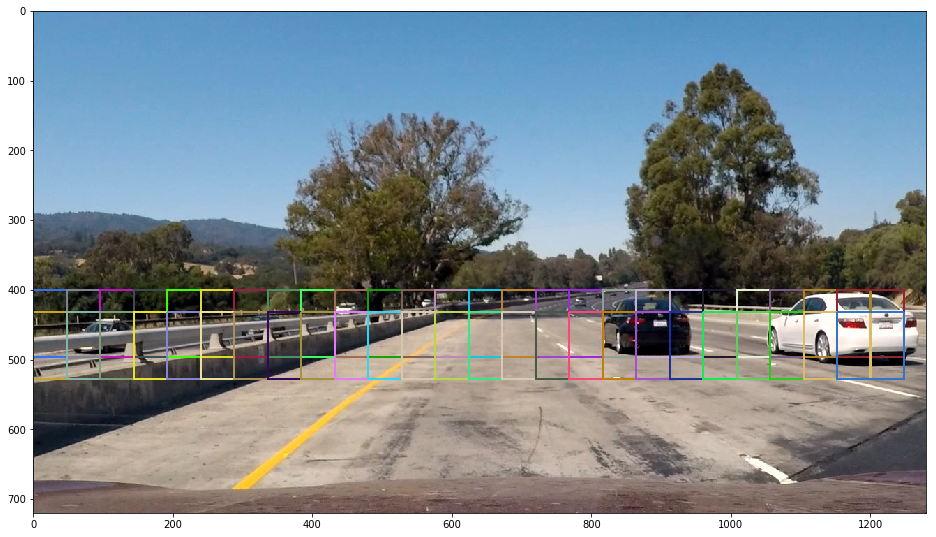

In [14]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                       pix_per_cell, cell_per_block, show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                       pix_per_cell, cell_per_block, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(16,16))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  38


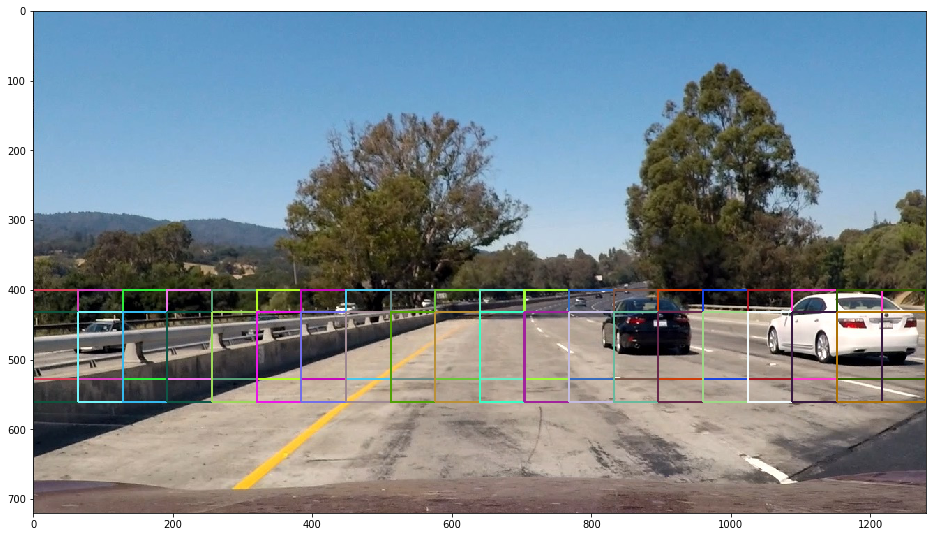

In [15]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 528
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                       pix_per_cell, cell_per_block, show_all_rectangles=True))
ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                       pix_per_cell, cell_per_block, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(16,16))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  24


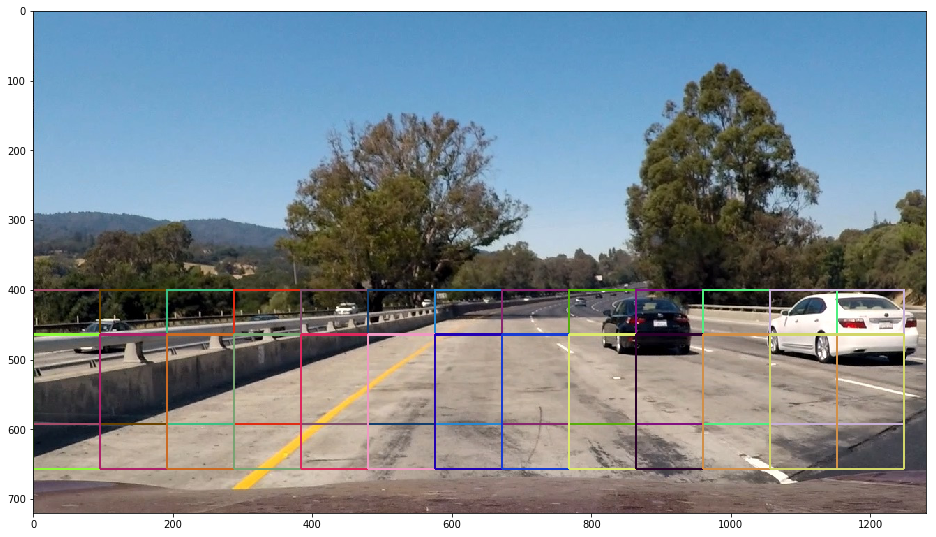

In [16]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, 
                       cell_per_block, show_all_rectangles=True))
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, 
                       cell_per_block, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(16,16))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

## Combine Various Sliding Window Searches

OK


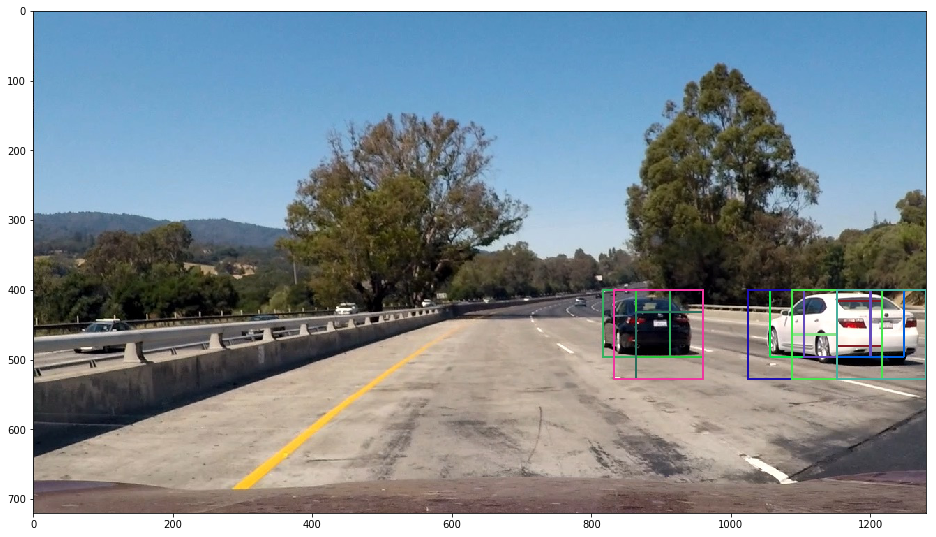

In [17]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                            pix_per_cell, cell_per_block))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                            pix_per_cell, cell_per_block))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient,
                            pix_per_cell, cell_per_block))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                            pix_per_cell, cell_per_block))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                            pix_per_cell, cell_per_block))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                            pix_per_cell, cell_per_block))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                            pix_per_cell, cell_per_block))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                            pix_per_cell, cell_per_block))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(16,16))
plt.imshow(test_img_rects)

print('OK')

- **Exploration findings:**    
A scale of less than 1.0 seemed to produce a lot of false positives.
The start and stop positions and scales used may need some tweaking in the future, depending on video performance.   
   
   
## Heatmap
This method (duplicated from lesson material) produces a heat map based on rectangle locations (additive with overlap).

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('OK')

OK


OK


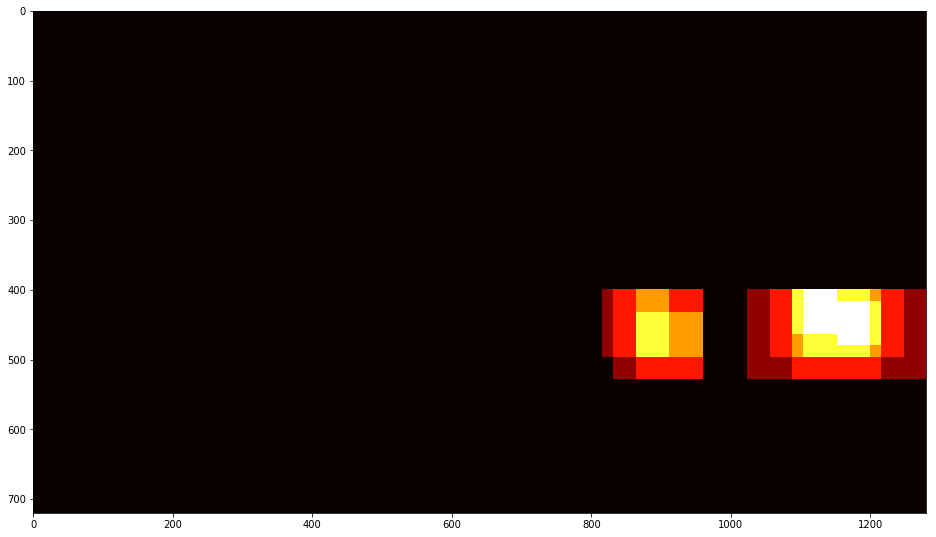

In [19]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(16,16))
plt.imshow(heatmap_img, cmap='hot')

print('OK')

## Apply a Threshold to the Heatmap

In [20]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('OK')

OK


OK


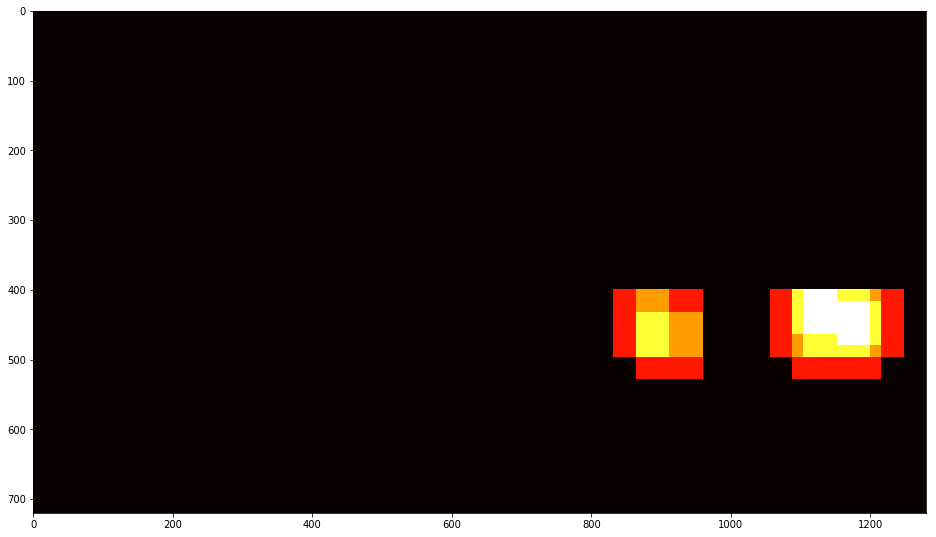

In [21]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(16,16))
plt.imshow(heatmap_img, cmap='hot')

print('OK')

## Apply SciPy Labels to Heatmap

2 cars found


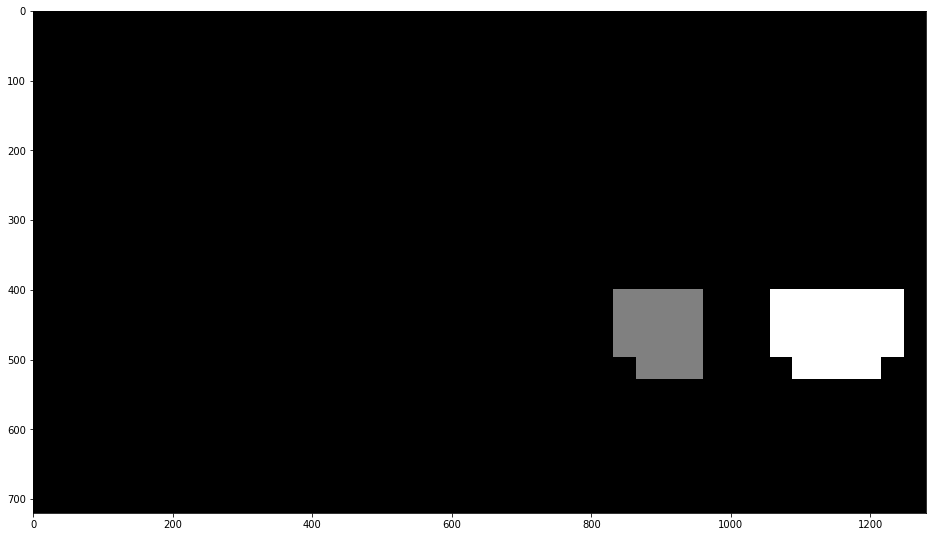

In [22]:
labels = label(heatmap_img)
plt.figure(figsize=(16, 16))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

## Draw Bounding Boxes for Lables

In [23]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    # Return the image and final rectangle
    return img, rects

print('OK!')

OK!


OK!


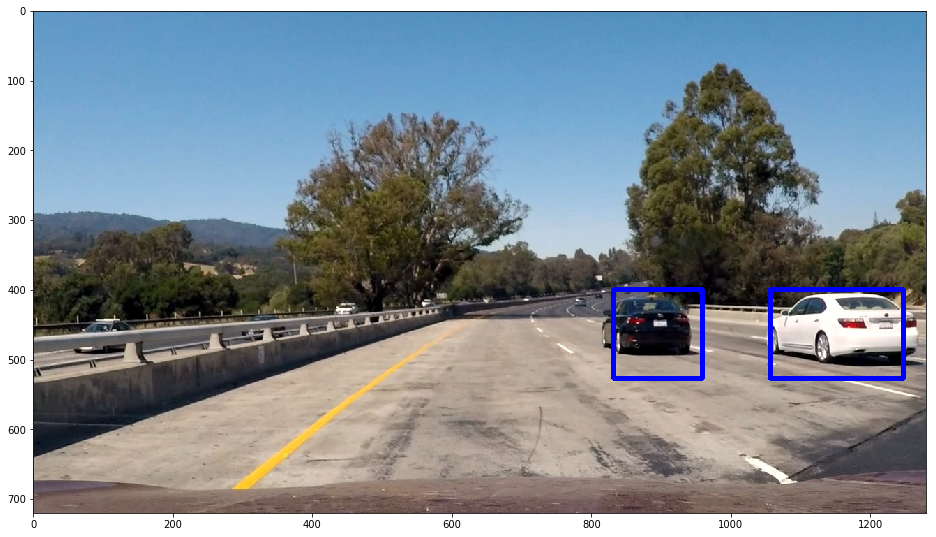

In [24]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(16,16))
plt.imshow(draw_img)

print('OK!')

## Combine All Together

In [25]:
def process_frame(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('Ok!')

Ok!


Run the pipeline on all the test images.

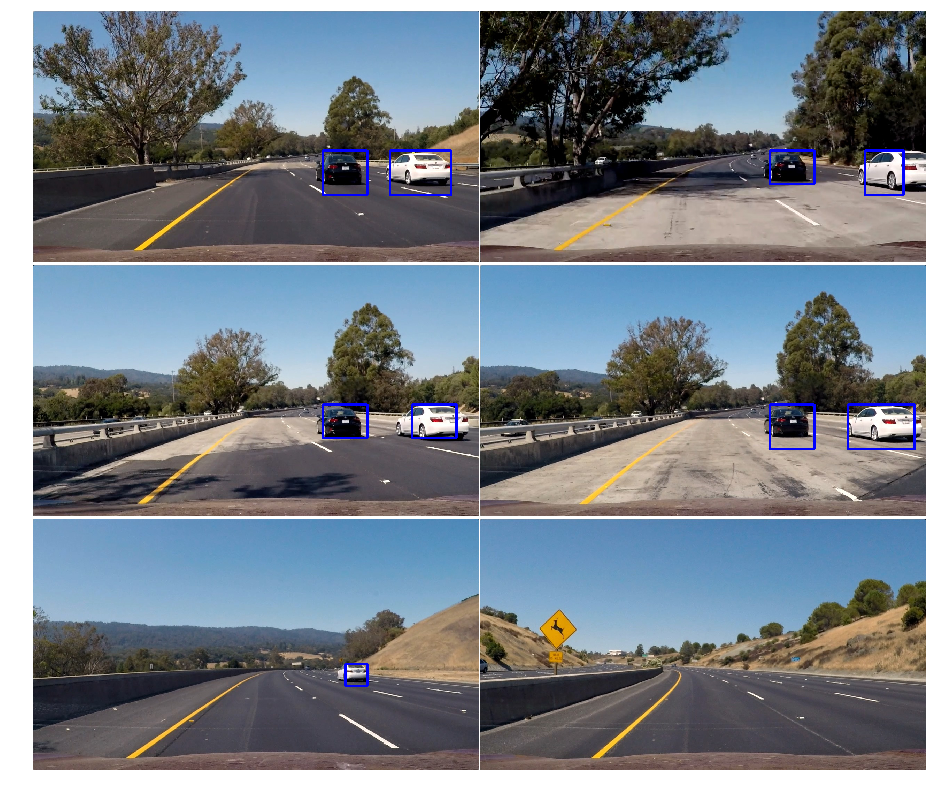

In [26]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

## Run a Video Through the Pipeline (primitive version)
This only processes a frame at a time without accounting for information from previous frames

In [27]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:07<00:00,  4.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 29.4 s, sys: 882 ms, total: 30.2 s
Wall time: 8.59 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

## Define a Class to Store Data from Vehicle Detections

In [29]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

print('OK！')

OK！


## Pipeline for Processing Video Frames

In [30]:
def process_frame_for_video(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, 
                                pix_per_cell, cell_per_block))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('OK')

OK


## Run a Video Through the Pipeline (advanced version)
This processes each frame while accounting for information from previous frames

In [31]:
det = Vehicle_Detect()

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:08<00:00,  4.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 29.6 s, sys: 993 ms, total: 30.6 s
Wall time: 9.2 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

In [33]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [04:37<00:00,  4.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 16min 1s, sys: 31.4 s, total: 16min 33s
Wall time: 4min 37s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))